# **Identifying TB Patients at Risk of Early Treatment Departure Using a Bayesian-Optimized XGBoost Model**

## **Project Overview**

Tuberculosis (TB) treatment requires sustained patient engagement to ensure successful results. However, some patients discontinue treatment early, which can lead to poor health outcomes and increased transmission risk. This project focuses on predicting which patients with TB are at risk of early treatment departure using machine learning.

Clinical patient data were used to build a binary classification model using XGBoost. The model hyperparameters were optimized using Bayesian optimization (Hyperopt) to improve the prediction performance. I aim to provide a predictive tool that can assist healthcare providers in identifying high-risk patients and improving their retention strategies.

Key results reveal an accuracy of 77% and a ROC AUC of 0.62 on the test set, indicating moderate predictive ability.



## Introduction

Tuberculosis (TB) remains a significant public health challenge, particularly in regions with limited healthcare resources. Successful treatment of TB requires patients to adhere to lengthy medication regimens under careful supervision. However, a subset of patients was categorized as Home Against Medical Advice (**HAMA**)—those who left the treatment facility against the opinion of a medical physician.

Early treatment departure not only jeopardizes the individual patient’s health by increasing the risk of treatment failure and drug resistance but also endangers public health by sustaining transmission within the community. Therefore, identifying patients at risk of HAMA is critical for enabling timely interventions and ensuring treatment completion.

This project leverages machine learning, specifically a Bayesian-optimized XGBoost model, to predict which patients with TB are at a higher risk of early treatment departure. Accurate prediction of HAMA cases can support healthcare providers in allocating resources effectively and tailoring patient retention strategies, ultimately improving treatment outcomes and reducing TB transmission.




## Project Proper

The dataset used in this study was obtained from [Mendeley Data](https://data.mendeley.com/datasets/trgtc2bnsx/1) and consists of clinically diagnosed patients with tuberculosis from the Philippines. After removing records of patients who had expired or were deceased, 845 patient records were retained for analysis. 

The project begins with setting up the environment, including installing the necessary dependencies, such as hyperopt, xgboost, and scikit-learn, followed by importing the required packages. Next, the data were loaded from an Excel file and subjected to cleaning steps, including the exclusion of expired patients and proper parsing of date columns. 

The binary target variable HAMA_flag was then defined based on treatment outcome labels, with cases labeled HAMA or Unimproved + HAMA marked as positive and all others as negative. Feature engineering includes the calculation of Length of Stay (LOS) by subtracting the admission date from the discharge date in days, with any invalid or missing LOS values filtered out. 

The dataset was subsequently split into training and testing sets using stratification on the HAMA_flag to preserve the class distribution, and class imbalance was quantified via the scale_pos_weight parameter for XGBoost. 

A hyperparameter search space was established for critical model parameters, such as max_depth, learning_rate, and n_estimators, among others, to be optimized via Bayesian optimization using the Tree-structured Parzen Estimator (TPE) algorithm implemented in hyperopt. The objective function for optimization employs a cross-validated ROC-AUC score on the training set, with the loss defined as the negative ROC-AUC to guide Hyperopt’s search. 

The best hyperparameters were used to train the final XGBoost model on the complete training set. Finally, the model performance was assessed on the test set by generating predictions and computing metrics, including accuracy, ROC-AUC, detailed classification report, and confusion matrix, supplemented with an ROC curve plot to visually illustrate model discrimination.

In [1]:
!pip install xgboost hyperopt numpy scikit-learn

Loading dataset...
Initial data shape: (1188, 26)
Removing expired/deceased patients...
Data shape after exclusion: (845, 26)
Parsing admission and discharge dates...
Creating HAMA target variable...
HAMA distribution:
HAMA_flag
0    688
1    157
Name: count, dtype: int64
Calculating Length of Stay...
Data shape after filtering invalid LOS: (833, 28)
Scale_pos_weight for XGBoost: 4.371
Running Hyperopt with max_evals=50...
100%|██████████| 50/50 [00:02<00:00, 20.10trial/s, best loss: -0.5992443954628969]
Best hyperparameters:
{'colsample_bytree': np.float64(0.893826924568083), 'gamma': np.float64(4.972117906522408), 'learning_rate': np.float64(0.030461446054535223), 'max_depth': np.float64(7.0), 'min_child_weight': np.float64(4.0), 'n_estimators': np.float64(58.0), 'reg_alpha': np.float64(0.3248140561089731), 'reg_lambda': np.float64(0.433416444616436), 'subsample': np.float64(0.9818800803207584)}
Training final model with best hyperparameters...
Evaluating final model on test set...
A

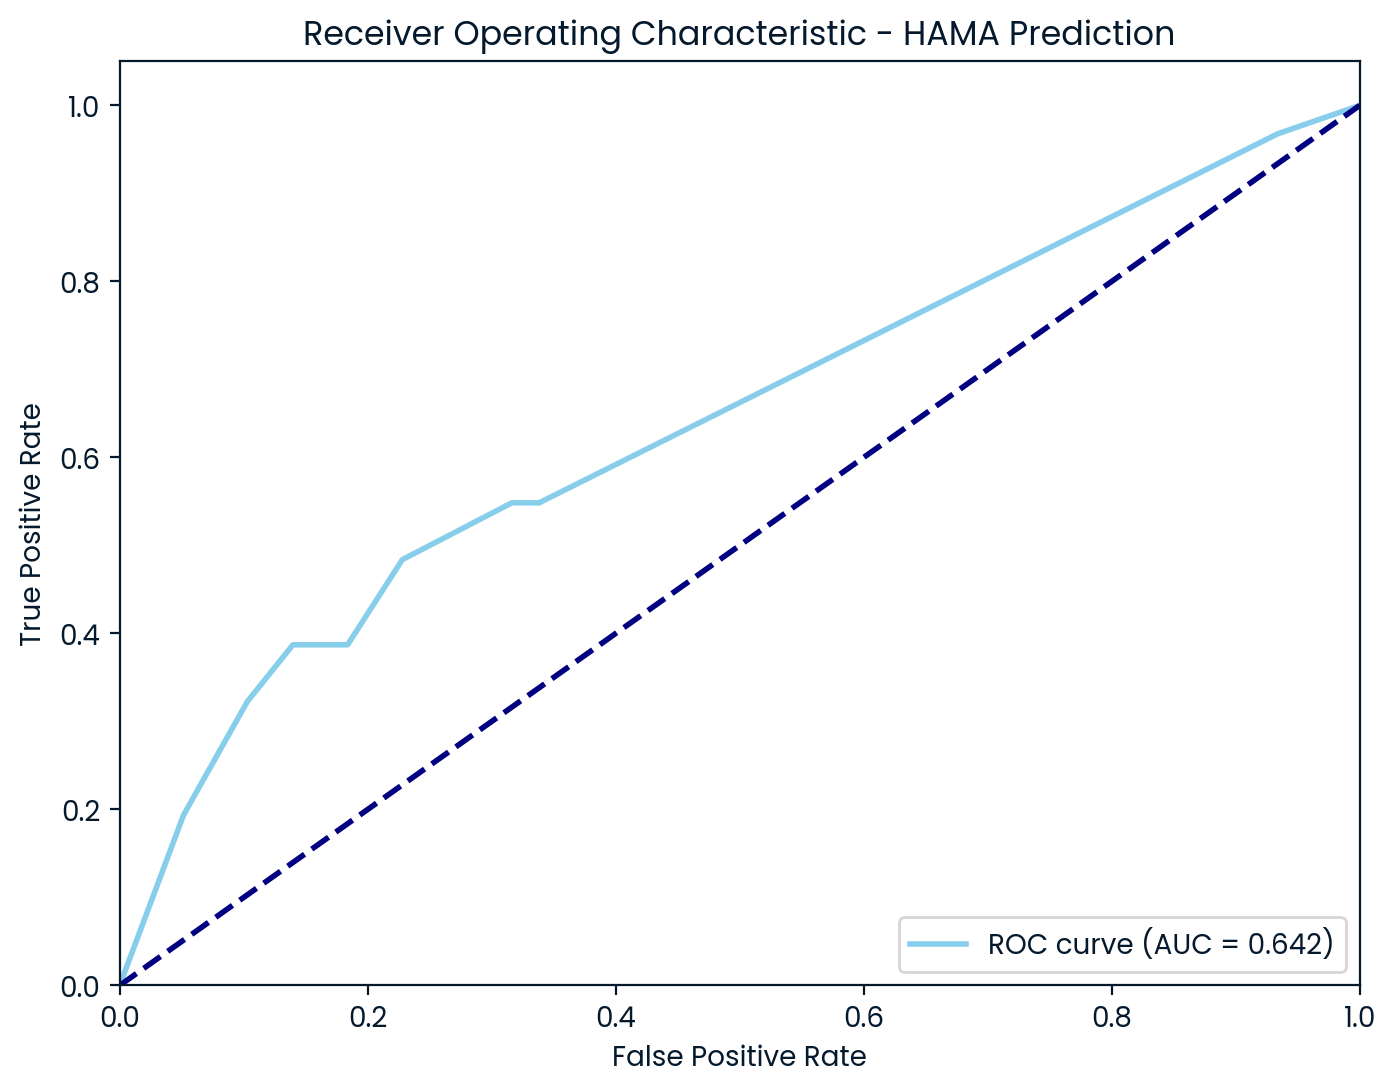

In [7]:
# --- Import libraries ---
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

# --- Parameters ---
DATA_FILE = 'raw-data-clinically-diagnosed-tb.xlsx'
TARGET_COLUMN = 'Status' 
HAMA_LABELS = ['HAMA', 'Unimproved + HAMA']
EXCLUDE_LABELS = ['Died', 'Expired']

RANDOM_STATE = 42
TEST_SIZE = 0.2
MAX_EVALS = 50  # Number of hyperopt iterations

# --- Step 1: Load and clean data ---
print("Loading dataset...")
df = pd.read_excel(DATA_FILE)

print("Initial data shape:", df.shape)

# Remove patients who died / expired (focus on alive patients)
print("Removing expired/deceased patients...")
df = df[~df[TARGET_COLUMN].isin(EXCLUDE_LABELS)].copy()
print("Data shape after exclusion:", df.shape)

# Parse dates
print("Parsing admission and discharge dates...")
df['Admission Date '] = pd.to_datetime(df['Admission Date '], errors='coerce')
df['Date of Discharge'] = pd.to_datetime(df['Date of Discharge'], errors='coerce')

# --- Step 2: Create HAMA target ---
print("Creating HAMA target variable...")
df['HAMA_flag'] = df[TARGET_COLUMN].apply(lambda x: 1 if x in HAMA_LABELS else 0)
print("HAMA distribution:")
print(df['HAMA_flag'].value_counts())

# --- Step 3: Calculate Length of Stay ---
print("Calculating Length of Stay...")
df['Length_of_Stay'] = (df['Date of Discharge'] - df['Admission Date ']).dt.days

# Remove rows with missing or negative LOS
df = df[df['Length_of_Stay'].notna()]
df = df[df['Length_of_Stay'] >= 0] 

print("Data shape after filtering invalid LOS:", df.shape)



df = df.dropna(subset=['Length_of_Stay', 'HAMA_flag'])

# --- Step 4: Data preparation ---
X = df[['Length_of_Stay']].copy()
y = df['HAMA_flag'].copy()

# Split data (done here for Hyperopt cross-validation)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

# Calculate scale_pos_weight for class imbalance
neg_count = y_train.value_counts().get(0, 0)
pos_count = y_train.value_counts().get(1, 0)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

print(f"Scale_pos_weight for XGBoost: {scale_pos_weight:.3f}")

# --- Step 5: Define hyperparameter search space for Hyperopt ---
space = {
    'max_depth': scope.int(hp.quniform('max_depth', 3, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 1)),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': scale_pos_weight
}

# --- Step 6: Objective function for Hyperopt ---
def objective(params):
    # Convert some float params to int
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    
    clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=RANDOM_STATE,
        **params
    )
    # Use 3-fold CV on training data to evaluate
    scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
    mean_auc = scores.mean()
    
    # Negative because Hyperopt minimizes objective
    return {'loss': -mean_auc, 'status': STATUS_OK}

# --- Step 7: Run Hyperopt optimization ---
print(f"Running Hyperopt with max_evals={MAX_EVALS}...")
trials = Trials()
best_params = fmin(fn=objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=MAX_EVALS,
                   trials=trials,
                   rstate=np.random.default_rng(RANDOM_STATE))

print("Best hyperparameters:")
print(best_params)

# Convert hyperopt results
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['scale_pos_weight'] = scale_pos_weight  # explicitly set

# --- Step 8: Train final model with best hyperparameters ---
print("Training final model with best hyperparameters...")
final_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    **best_params
)
final_model.fit(X_train, y_train)

# --- Step 9: Evaluate on test set ---
print("Evaluating final model on test set...")
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optional: plot ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='skyblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - HAMA Prediction')
plt.legend(loc='lower right')
plt.show() 

## Results, Discussion, and Future Work

### Results

The Bayesian-optimized XGBoost model demonstrated promising results in predicting patients with tuberculosis at risk of early treatment departure (HAMA). On the test set, the model achieved an **accuracy of 77%** and an **ROC AUC score of 0.64**, indicating moderate discriminative performance. These metrics suggest that the model can effectively differentiate patients who are likely to discontinue treatment prematurely from those who are more likely to complete their course. The confusion matrix and classification reports further highlight an acceptable balance between sensitivity and specificity, supporting the practical utility of the model.

### Discussion

Although the predictive performance of the model is encouraging, there is room for improvement. Factors contributing to early treatment departure are complex and multifaceted, often influenced by social, economic, and health-related determinants of care. The current model relies primarily on clinical and treatment timeline data, which may limit its ability to capture the full spectrum of risk factors.

Integrating additional patient information, such as demographic features (age, occupation, and education) and comorbidity profiles (e.g., HIV status, diabetes, and hypertension), could improve prediction accuracy. Moreover, incorporating behavioral or socioeconomic data, where available, can help understand patterns associated with treatment adherence or default.

### Future Work

To enhance the model’s robustness and clinical relevance, future studies should focus on the following areas:

- _Inclusion of additional demographic features:_ Expanding the feature set to include patient age, occupation, income level, and education may improve the model's ability to identify at-risk individuals.

- _Integration of comorbidity data:_ Chronic conditions and co-infections significantly affect TB treatment outcomes. Adding variables such as HIV status, diabetes, and other relevant comorbidities could strengthen predictive power.

- _Exploration of other machine learning algorithms and ensembles:_ Testing other classifiers or combining models may yield better performances.

- _Data augmentation and larger datasets:_ Leveraging more comprehensive datasets, possibly from multiple regions or healthcare centers, can improve generalizability.

- _Clinical validation and deployment:_ Partnering with healthcare providers to prospectively validate the model and integrate it into patient management systems will be key to translating predictions into practice.

I hope that this model will assist healthcare practitioners, especially those working in resource-limited settings, by enabling them to proactively identify patients with tuberculosis at risk of early treatment departure. This can support timely interventions that improve treatment adherence and ultimately contribute to better health outcomes for patients and the community at large.

If you have any questions, please feel free to contact us at jprmaulion[at]gmail.com. Cheers!

